In [30]:
# define the system
from IPython.display import display
import ipywidgets as ipw
import numpy as np
import bqplot as bqp
import ipyvolume as ipv

np.seterr(divide='ignore', invalid='ignore') # divisions by errors will occur

def y(x):
    return(np.exp(-0.1*x) * np.sin(x))

def Y(s1, s2):
    s = s1 +  1j * s2
    try:
        Y = 1 / s
        return(Y.real, Y.imag)
    except:
        return(np.inf, np.inf) 

tArray = np.linspace(0, 10, 100)
s1Array = np.linspace(-10, 10, 101) # make sure both of them don't pass through 0 to avoid infinity
s2Array = np.linspace(-10, 10, 101)

yArray = y(tArray)
s1Grid, s2Grid = np.meshgrid(s1Array, s2Array)
temp1, temp2 = np.array(Y(np.ravel(s1Grid), np.ravel(s2Grid)))
Y1Array = temp1.reshape(s1Grid.shape)
Y2Array = temp2.reshape(s1Grid.shape)

isContinousUpdateOn = True # when turned on it's sluggish without throttling

In [31]:
# helper functions
def amplitude(sigma, omega):
    return(np.sqrt(sigma**2 + omega**2))

# throttling as per https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html
import asyncio
from time import time

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback
        self._task = asyncio.ensure_future(self._job())

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def cancel(self):
        self._task.cancel()
        
def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled = False
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args = args
            new_kwargs = kwargs
            if not scheduled:
                new_wait = max(0, wait - time_since_last_call)
                Timer(new_wait, call_it)
                scheduled = True
        return throttled
    return decorator

In [32]:
# sliders styling and whatnot, normally should be hidden from view
tSlider = ipw.FloatSlider(
    value=tArray[0],
    min=np.min(tArray), 
    max=np.max(tArray),
    description='$t$:',
    disabled=False, 
    step=tArray[1] - tArray[0],
    readout=True,
    readout_format='.2f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='100%', height='80px'), 
)
ySlider = ipw.FloatSlider(
    value=yArray[0],
    min=np.min(yArray), 
    max=np.max(yArray),
    description='$y$:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='100%', height='80px'), 
)
s1Slider = ipw.FloatSlider(
    value=s1Array[0],
    min=np.min(s1Array), 
    max=np.max(s1Array), 
    description='Real[$s$]:',
    disabled=False,
    step=s1Array[1] - s1Array[0],
    readout=True,
    readout_format='.2f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'),  
)
s2Slider = ipw.FloatSlider(
    value=s2Array[0],
    min=np.min(s2Array), 
    max=np.max(s2Array), 
    description='Imag[$s$]:',
    disabled=False,
    step=s2Array[1] - s2Array[0],
    readout=True,
    readout_format='.2f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'), 
)
Y1Slider = ipw.FloatSlider(
    value=Y1Array[0,0],
    min=np.nanmin(Y1Array[Y1Array != -np.inf]), 
    max=np.nanmax(Y1Array[Y1Array != np.inf]), 
    description='Real[$Y(s)$]:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'), 
)
Y2Slider = ipw.FloatSlider(
    value=Y2Array[0,0],
    min=np.nanmin(Y2Array[Y2Array != -np.inf]), 
    max=np.nanmax(Y2Array[Y2Array != np.inf]), 
    description='Imag[$Y(s)$]:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'), 
)
fourierCheckbox = ipw.Checkbox(
    value=False,
    description='Fourier Mode',
    disabled=False,
    indent=False
)
showPolesCheckbox = ipw.Checkbox(
    value=True,
    description='Show poles',
    disabled=False,
    indent=False
)
showZerosCheckbox = ipw.Checkbox(
    value=True,
    description='Show zeros',
    disabled=False,
    indent=False
)

In [5]:
# reset sliders
tSlider.value = tArray[0]
ySlider.value = yArray[0]
s1Slider.value = s1Array[0] 
s2Slider.value = s2Array[0]
Y1Slider.value = Y1Array[0,0]
Y2Slider.value = Y2Array[0,0]
fourierCheckbox.value = False

# bqplot slider & plot interaction 

In [33]:
animDuration = 100
centerAxisLineOffset = 1
halfWidthFigLayout = ipw.Layout(width='50%', height='400px')

# t->y(t) plot
xSc = bqp.LinearScale()
ySc = bqp.LinearScale()
xAxis = bqp.Axis(label='t', scale=xSc, tick_format='0.0f', grid_lines='none')
yAxis = bqp.Axis(label='y(t)', scale=ySc, orientation='vertical', tick_format='0.1f', grid_lines='none')
yLine = bqp.Lines(x=tArray, y=yArray, scales={'x': xSc, 'y': ySc}, labels=['y'], display_legend=True)
yPoint = bqp.Scatter(x=[tSlider.value], y=[ySlider.value], scales={'x': xSc, 'y': ySc}, default_size=128)
#label = bqp.Label(x=[tArray[0]], y=[yArray[0]], scales={'x': xSc, 'y': ySc}, x_offset = 5, y_offset = 5, text=['{:.4f}'.format(yArray[0])])
tyFig = bqp.Figure(axes=[xAxis, yAxis],  marks=[yLine, yPoint], title='y(t) = {:.4f}'.format(yArray[0]), layout=ipw.Layout(width='90%', height='400px'), animation_duration=animDuration)

# s & Y(t) plots
s1Sc = bqp.LinearScale()
s1Sc.min = np.min(s1Array)
s1Sc.max = np.max(s1Array)
s2Sc = bqp.LinearScale()
s2Sc.min = np.min(s2Array)
s2Sc.max = np.max(s2Array)
Y1Sc = bqp.LinearScale()
Y1Sc.min = -1 #np.min(Y1Array)
Y1Sc.max = 1 #np.max(Y1Array)
Y2Sc = bqp.LinearScale()
Y2Sc.min = -1 #np.min(Y2Array)
Y2Sc.max = 1 #np.max(Y2Array)
s1Axis = bqp.Axis(label='Real', scale=s1Sc, tick_format='0.0f', grid_lines='none')
s2Axis = bqp.Axis(label='Imaginary', scale=s2Sc, orientation='vertical', tick_format='0.0f', grid_lines='none')
Y1Axis = bqp.Axis(label='Real', scale=Y1Sc, tick_format='0.0f', grid_lines='none')
Y2Axis = bqp.Axis(label='Imaginary', scale=Y2Sc, orientation='vertical', tick_format='0.0f', grid_lines='none')
sRealLine = bqp.Lines(x=[s1Sc.min - centerAxisLineOffset, s1Sc.max + centerAxisLineOffset], y=[0,0], scales={'x': s1Sc, 'y': s2Sc}, colors=['black'], stroke_width=0.5)
sImagLine = bqp.Lines(x=[0,0], y=[s2Sc.min - centerAxisLineOffset, s2Sc.max + centerAxisLineOffset], scales={'x': s1Sc, 'y': s2Sc}, colors=['black'], stroke_width=0.5)
YRealLine = bqp.Lines(x=[Y1Sc.min - centerAxisLineOffset, Y1Sc.max + centerAxisLineOffset], y=[0,0], scales={'x': Y1Sc, 'y': Y2Sc}, colors=['black'], stroke_width=0.5)
YImagLine = bqp.Lines(x=[0,0], y=[Y2Sc.min - centerAxisLineOffset, Y2Sc.max + centerAxisLineOffset], scales={'x': Y1Sc, 'y': Y2Sc}, colors=['black'], stroke_width=0.5)
inputPoint = bqp.Scatter(x=[s1Slider.value], y=[s2Slider.value], scales={'x': s1Sc, 'y': s2Sc}, enable_move=True, colors=['red'])
outputPoint = bqp.Scatter(x=[Y1Slider.value], y=[Y2Slider.value], scales={'x': Y1Sc, 'y': Y2Sc})
dragHint = bqp.Label(x=[0], y=[s2Sc.max], scales={'x': s1Sc, 'y': s2Sc}, x_offset = -30, y_offset = 0, text=['Drag me!'])
sFig = bqp.Figure(axes=[s1Axis, s2Axis], marks=[sRealLine, sImagLine, dragHint, inputPoint], title='s = {:.2f}, {:.2f}j'.format(s1Slider.value, s2Slider.value), layout=halfWidthFigLayout,  animation_duration=animDuration)
YFig = bqp.Figure(axes=[Y1Axis, Y2Axis], marks=[YRealLine, YImagLine, outputPoint], title='Y(s) = {:.2f}, {:.2f}j'.format(Y1Slider.value, Y2Slider.value), layout=halfWidthFigLayout, animation_duration=animDuration)

# freq->amplitude plot
r1, r2 = Y(s1Slider.value, s2Array)
ampArray = amplitude(r1, r2)

freqSc = bqp.LinearScale()
ampSc = bqp.LinearScale()
freqAxis = bqp.Axis(label='Frequency (Imag[s])', scale=freqSc, tick_format='.0f', grid_lines='none')
ampAxis = bqp.Axis(label='Amplitude', scale=ampSc, orientation='vertical', tick_format='.1f', grid_lines='none')
ampLine = bqp.Lines(x=s2Array, y=ampArray, scales={'x': freqSc, 'y': ampSc})
ampPoint = bqp.Scatter(x=[s2Slider.value], y=[amplitude(Y1Slider.value, Y2Slider.value)], scales={'x': freqSc, 'y': ampSc}, default_size=128)
freqampFig = bqp.Figure(axes=[freqAxis, ampAxis],  marks=[ampLine, ampPoint], title='Amplitude[Y(s)] = {:.2f}'.format(amplitude(Y1Slider.value, Y2Slider.value)), layout=halfWidthFigLayout, animation_duration=animDuration)

# EXPERIMENTAL
# 3d amplitude plot
amp3dFig = ipv.figure(xlabel='Real[s]', ylabel='Amplitude[Y(s)]', zlabel='Imag[s]', title='Amplitude[Y(s)] = {:.2f}'.format(amplitude(Y1Slider.value, Y2Slider.value)), layout=ipw.Layout(width='50%', height='600px'), animation_duration=animDuration)
temp = np.array(amplitude(np.ravel(Y1Array), np.ravel(Y2Array)))
ampGrid = temp.reshape(Y1Array.shape)
amp3dPoint = ipv.scatter(x=np.array([s1Slider.value]), y=np.array([amplitude(Y1Slider.value, Y2Slider.value)]), z=np.array([s2Slider.value]), marker='sphere', size=5, color='blue')
amp3dSurface = ipv.plot_surface(x=s1Grid, y=ampGrid, z=s2Grid, color="skyblue")
#

@throttle(0.5)
def handle_tSlider(change):
    tValue = change['new']
    updateRealDomain(tValue)

def updateRealDomain(tValue):  
    yValue = y(tValue)
    ySlider.value = yValue
    yPoint.x = [tValue]
    yPoint.y = [yValue]
    tyFig.title = 'y(t) = {:.4f}'.format(yValue)

@throttle(0.5)    
def handle_s1Slider(change):
    s1Value = change['new']
    s2Value = s2Slider.value
    updateComplexDomain(s1Value, s2Value)
    
@throttle(0.5)    
def handle_s2Slider(change):
    s1Value = s1Slider.value
    s2Value = change['new'] 
    updateComplexDomain(s1Value, s2Value)
    
@throttle(0.5)
def handle_dragging(name, value):
    s1Slider.value = value['point']['x']
    s2Slider.value = value['point']['y']
    dragHint.text = ['']

def handle_fourierCheckbox(change):
    if change['new'] == True:
        s1Slider.value = 0
        s1Slider.disabled = True
        inputPoint.restrict_y = True
    else:
        s1Slider.disabled = False
        inputPoint.restrict_y = False
        
def updateComplexDomain(s1Value, s2Value):
    # input plot
    inputPoint.x = [s1Value]
    inputPoint.y = [s2Value]
    sFig.title = 's = {:.2f}, {:.2f}j'.format(s1Value, s2Value)
    
    # output plot
    Y1Value, Y2Value = Y(s1Value, s2Value)
    outputPoint.visible = True
    
    if(Y1Value > Y1Slider.max or Y1Value < Y1Slider.min):
        Y1Slider.readout = False
        outputPoint.visible = False
    else:
        Y1Slider.readout = True  
        
    if(Y2Value > Y2Slider.max or Y2Value < Y2Slider.min):
        Y2Slider.readout = False
        outputPoint.visible = False
    else:
        Y2Slider.readout = True

    Y1Slider.value = Y1Value
    Y2Slider.value = Y2Value
    outputPoint.x = [Y1Value]
    outputPoint.y = [Y2Value]
    YFig.title = 'Y(s) = {:.2f}, {:.2f}j'.format(Y1Value, Y2Value)
    
    # fourier plot
    r1, r2 = Y(s1Value, s2Array)
    ampArray = amplitude(r1, r2)
    ampLine.y = ampArray
    ampPoint.x = [s2Value] 
    ampPoint.y = [amplitude(Y1Value, Y2Value)]
    freqampFig.title = 'Amplitude[Y(s)] = {:.2f}'.format(amplitude(Y1Value, Y2Value))
    
    # 3d amplitude plot
    amp3dPoint.x = np.array([s1Value])
    amp3dPoint.z = np.array([s2Value])
    amp3dPoint.y = np.array([amplitude(Y1Slider.value, Y2Slider.value)])
    
# event links
tSlider.observe(handle_tSlider, names='value')
s1Slider.observe(handle_s1Slider, names='value')    
s2Slider.observe(handle_s2Slider, names='value')        
fourierCheckbox.observe(handle_fourierCheckbox, names='value')    
inputPoint.on_drag_end(handle_dragging)   

In [34]:
display(ipw.VBox([ipw.HBox([tSlider, ySlider]), tyFig]))
display(ipw.VBox([ipw.HBox([s1Slider, Y1Slider]), ipw.HBox([s2Slider, Y2Slider]), ipw.HBox([fourierCheckbox, showPolesCheckbox, showZerosCheckbox])]))
display(ipw.HBox([sFig, YFig]))    
display(ipw.HBox([freqampFig, amp3dFig]))

## COMPARISON: matplotlib slider & plot interaction 

In [29]:
from matplotlib import pyplot as plt
#%matplotlib inline # DOES NOT WORK/UPDATE
%matplotlib widget
fig = plt.figure()
ax = fig.gca()
hPlot = ax.plot(tArray, yArray, linewidth=2, label='$y$');
hScatter = ax.scatter(tArray[0], yArray[0], 50)
hText = ax.text(tArray[0], yArray[0], ' ${:.3f}$'.format(yArray[0]))
ax.set_xlabel('$t$');
ax.set_ylabel('$y(t)$');
plt.legend(loc="best");

def handle_tSlider_change(change): 
    tValue = change['new']
    yValue = y(tValue)
    ySlider.value = yValue
    hScatter.set_offsets((tValue, yValue))
    hText.set_position((tValue, yValue))
    hText.set_text(' ${:.3f}$'.format(yValue))
tSlider.observe(handle_tSlider_change, names='value')

display(ipw.HBox([tSlider, ySlider]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# linking widgets

In [28]:
a = ipw.FloatText()
b = ipw.FloatSlider()
display(a,b)

mylink = ipw.jslink((a, 'value'), (b, 'value'))

FloatText(value=0.0)

FloatSlider(value=0.0)

# sympy laplace transform test

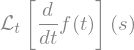

In [15]:
import sympy as sy
from sympy.abc import t, s, a
sy.init_printing()
f = sy.Function('f')
sy.laplace_transform(f(t).diff(), t, s)

# draggable points in matplotlib example 
https://stackoverflow.com/questions/50439506/dragging-points-in-matplotlib-interactive-plot

# other notes

In [27]:
import matplotlib.pyplot as plt
%matplotlib widget
def fun(x, y):
    x, y = Y(x, y)
    return np.sqrt(x**2 + y**2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(s1Array, s2Array)
zs = np.array(fun(np.ravel(x), np.ravel(y)))
z = zs.reshape(x.shape)
ax.plot_surface(x, y, z)
ax.set_zlim(0, 5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

c:\python36\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


In [26]:
import ipywidgets as widgets

out = widgets.Output()
def on_value_change(change):
    with out:
        print(change['new'])

slider = widgets.IntSlider(min=1, max=100, step=1, continuous_update=True)
play = widgets.Play(min=1, interval=2000)

slider.observe(on_value_change, 'value')
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.VBox([play, slider, out])